# Machine Learning Engineer Nanodegree

### Capstone Project: Starbucks’ Capstone Challenge - Notebook 5.

***Maria Balog  
May 25th, 2020***

### Recap

This project is broken down into a number of notebooks to facilitate ease of testing and trouble-shooting. This is the fifth notebook of this project, for a full description of the problem, please refer to the first notebook [*here*](Starbucks_Capstone_notebook.ipynb).

In brief, we have a month worth of data for about 15,000 users who may or may not have acted upon digital offers received from Starbucks. 

### Problem Statement

Our main areas of query are, for what demographic groups and what offer types  
- are offers most likely to be viewed within their valid duration?
- are offers most likely to be completed, given that they were viewed?
- can we find a correlation between an offer being viewed and the total amount of transactions within the duration of the offer?


### Implementation

The implementation of the solution consists of the following steps:
- data cleaning and visualization (see [*Notebook 1.*](Starbucks_Capstone_notebook.ipynb))
- feature engineering (see [*Notebook 2.*](Starbucks_Capstone_notebook3.ipynb))
- applying KMeans clustering to examine viewing rates (see [*Notebook 3.*](Starbucks_Capstone_notebook4.ipynb))
- applying KMeans clustering to examine completion rates (see [*Notebook 4.*](Starbucks_Capstone_notebook5.ipynb))
- applying KMeans clustering to examine total transaction amounts
- final evaluation and conclusions

In this notebook, we will focus on the fourth step: **applying KMeans clustering to examine total transaction amounts**.

In this case, we need to examine the combination of the `offer_received`, `offer_viewed` and `transaction` datasets, joined with the `portfolio` and `profile` datasets using their appropriate ids.

We have already created this dataset in a previous notebook, so let's load it in!

In [1]:
import pandas as pd
import numpy as np
import math

dtype_otp  = {'age': np.int8,  'male': np.int8,  'female': np.int8,  'other': np.int8 ,
              'member_days': np.int16,  'reward': np.int8,  'difficulty': np.int8,
              'duration': np.int16,  'web': np.int8,  'mobile': np.int8,  'social': np.int8,
              'bogo': np.int8,  'disc': np.int8,  'is_completed': np.int8 } 
offer_trans = pd.read_csv('data/offer_transaction_profile.csv', dtype=dtype_otp)
offer_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49890 entries, 0 to 49889
Data columns (total 16 columns):
valid_flag     49890 non-null int64
log_amount     49890 non-null float64
age            49890 non-null int8
income         49890 non-null float64
member_days    49890 non-null int16
female         49890 non-null int8
male           49890 non-null int8
other          49890 non-null int8
reward         49890 non-null int8
difficulty     49890 non-null int8
duration       49890 non-null int16
web            49890 non-null int8
mobile         49890 non-null int8
social         49890 non-null int8
bogo           49890 non-null int8
disc           49890 non-null int8
dtypes: float64(2), int16(2), int64(1), int8(11)
memory usage: 1.9 MB


In [2]:

df = offer_trans.corr().round(2)
df[['log_amount', 'valid_flag']].style.background_gradient(cmap='Blues')

,log_amount,valid_flag
valid_flag,0.16,1
log_amount,1,0.16
age,0.2,0.02
income,0.47,0.03
member_days,0.11,0.02
female,0.24,0.01
male,-0.25,-0.01
other,0.02,0.01
reward,-0.04,0.02
difficulty,0.01,-0.15


Again, this is the combination of the demographic data and the properties of the offers that were received, possibly viewed and the total amount spent by each user.

Implementing KMeans clustering and interpreting the data requires the following steps:

- standardization
- principal component analysis (PCA)
- determining the optimal K value(s)
- performing KMeans clustering
- reversing PCA and standardization on the cluster centers
- interpreting the results


### Standardization

First we need to standardize the data, so that each column's mean is `0` and their standard deviation is `1`.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_otp = pd.DataFrame(scaler.fit_transform(offer_trans.astype(float)))
scaled_otp.columns = offer_trans.columns
scaled_otp.describe().round(4)

,valid_flag,log_amount,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,disc
count,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000,49890.0000
mean,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-1.3214,-1.9903,-2.0245,-1.5998,-1.3231,-0.8294,-1.1711,-0.1197,-1.1102,-1.0459,-1.1868,-2.5793,-2.9599,-1.4354,-1.0587,-0.9445
25%,-1.3214,-0.7674,-0.7181,-0.7972,-0.7832,-0.8294,-1.1711,-0.1197,-0.7835,-1.0459,-1.1868,0.3877,0.3378,-1.4354,-1.0587,-0.9445
50%,0.7568,0.0165,0.0771,-0.0891,-0.2947,-0.8294,0.8539,-0.1197,-0.1301,0.1538,-0.0653,0.3877,0.3378,0.6967,0.9445,-0.9445
75%,0.7568,0.7679,0.7019,0.6191,0.6589,1.2057,0.8539,-0.1197,1.5035,0.1538,-0.0653,0.3877,0.3378,0.6967,0.9445,1.0587
max,0.7568,2.1891,2.6899,2.6491,2.9377,1.2057,0.8539,8.3526,1.5035,2.5533,1.6170,0.3877,0.3378,0.6967,0.9445,1.0587


### Principal Component Analysis for Dimentionality Reduction

Next, we can examine the principal components of this dataset.

#### *Figuring out how many principal components to keep*

In [4]:
# first set PCA components to the number of features -1
pca = PCA(n_components=14)
pca.fit(scaled_otp)

explained_vr = pca.explained_variance_ratio_.round(4)

# cheking the sums of the explained variance for the first ii components
for ii in range(1,13):
    print('Variance percentage with {} components: {}%'.format(ii, (explained_vr[:ii].sum()*100).round(2)))

Variance percentage with 1 components: 25.73%
Variance percentage with 2 components: 40.38%
Variance percentage with 3 components: 52.17%
Variance percentage with 4 components: 60.77%
Variance percentage with 5 components: 68.43%
Variance percentage with 6 components: 74.87%
Variance percentage with 7 components: 81.08%
Variance percentage with 8 components: 86.15%
Variance percentage with 9 components: 90.75%
Variance percentage with 10 components: 94.43%
Variance percentage with 11 components: 97.45%
Variance percentage with 12 components: 99.04%


This means that by keeping the first ten components, we can retain almost 95% of variability of the data. 

#### *Visualizing the top ten principal components*

Below is a visual representation of the composition of the first ten components (here I use absolute values because I am only interested in the weight of the columns in each component).

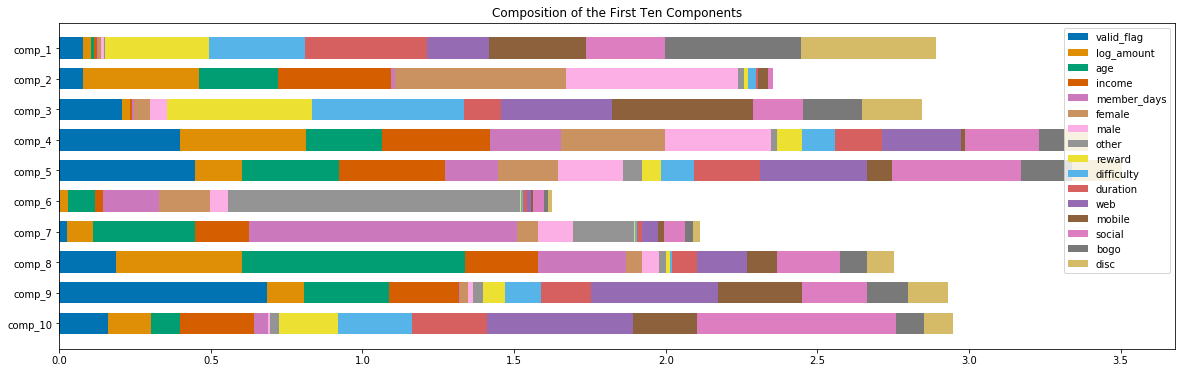

In [5]:
import sys  
sys.path.insert(0, './source')
        
import sb_data_visualization as dv
import sb_modeling as modeling

import matplotlib.pyplot as plt
%matplotlib inline

# convert the array of principal components to a dataframe
data = pd.DataFrame(np.abs(pca.components_[:10]))

rows = ['comp_'+str(ii) for ii in range(1, 11)]
columns = offer_trans.columns

data.index = rows    
data.columns = columns

dv.display_principal_components(data) 

So keeping ten principal components and retaining close to 95% variability of the data seems reasonable. 

In [6]:
# keep however many components result in retaining 95% variability
pca2 = PCA(.94)
pca2.fit(scaled_otp)

explained_vr = pca2.explained_variance_ratio_.round(4)
print('\nExplained Variance Ratio: \n', explained_vr)

# the new column names are the previously generated "row" names, comp_1 to comp_10
trans_data = pd.DataFrame(pca2.transform(scaled_otp), columns=rows)
trans_data.head().round(2)


Explained Variance Ratio: 
 [0.2573 0.1465 0.1179 0.086  0.0766 0.0644 0.0621 0.0507 0.046  0.0368]


,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10
0,-1.74,-1.13,-0.59,0.50,1.18,-0.04,-0.06,-1.04,1.13,-0.80
1,-1.92,-1.31,-0.99,0.05,0.11,-0.07,-0.09,-1.07,-0.41,-0.59
2,1.75,-0.91,-1.34,-1.24,-1.07,-0.13,-0.14,-0.96,0.66,-0.21
3,1.81,-0.68,-0.80,-0.09,1.32,-0.01,0.08,-1.60,1.48,0.59
4,-0.83,0.55,-0.44,0.76,-0.11,8.43,1.60,-1.61,-0.49,1.33


Now let's move on to fitting our clustering algorithms.

### Determining the Optimal Number of Clusters

First, let's try to use the elbow method to figure out the optimal number of clusters. Since we have ten types of promotions, I'm hoping we would have a number of clusters close to that.

Wall time: 55.1 s


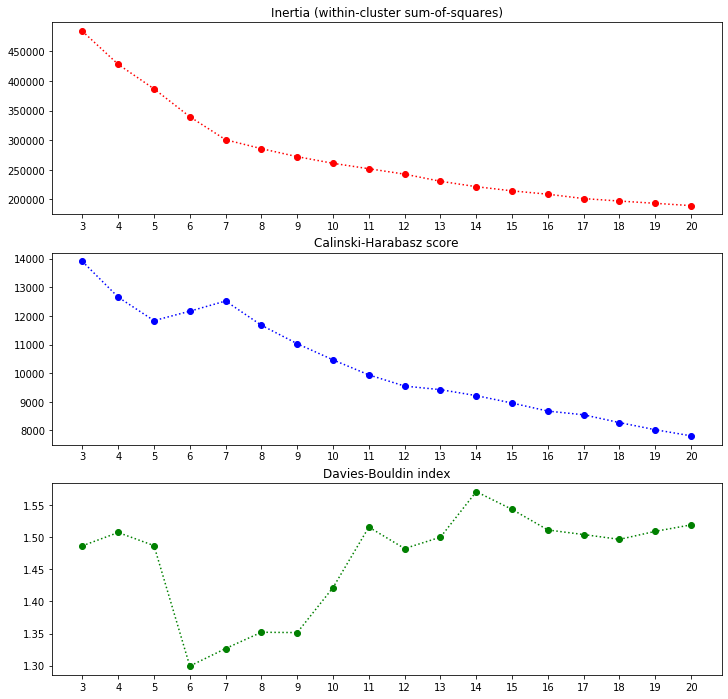

In [7]:
%%time

modeling.init_metrics(trans_data)
modeling.display_metrics()

Well, the first curve has a great elbow at `k=7`, I have also run this  with different random seeds (0, 1 and 2) and I got similar curves every time.

In the second chart, higher values indicate better defined clusters, so ideally we are looking for local maximums, again, `k=7` is by far the best candidate. Values in the third chart indicate the average ‘similarity’ between clusters, and this time the ideal values are the local minima. This technically does not apply to `k=7`, but considering how it is still one of the lowest values in this range, and it is the best choice based on the other two charts, this should be the `k` value we first consider.

Let's also examine if the number of datapoints falling in each cluster for a range of `k` values would give us a clue. To that end, we can visualize the cluster sizes in various ways for `k` values ranging from 3 to 20, see if we can discover any trends.

In [8]:
%%time 
n = 21
results = pd.DataFrame(index=range(n-1))
for ii in range(3, n):
    results['count'+str(ii)] = modeling.get_cluster_counts(trans_data, n, ii)


Wall time: 55.1 s


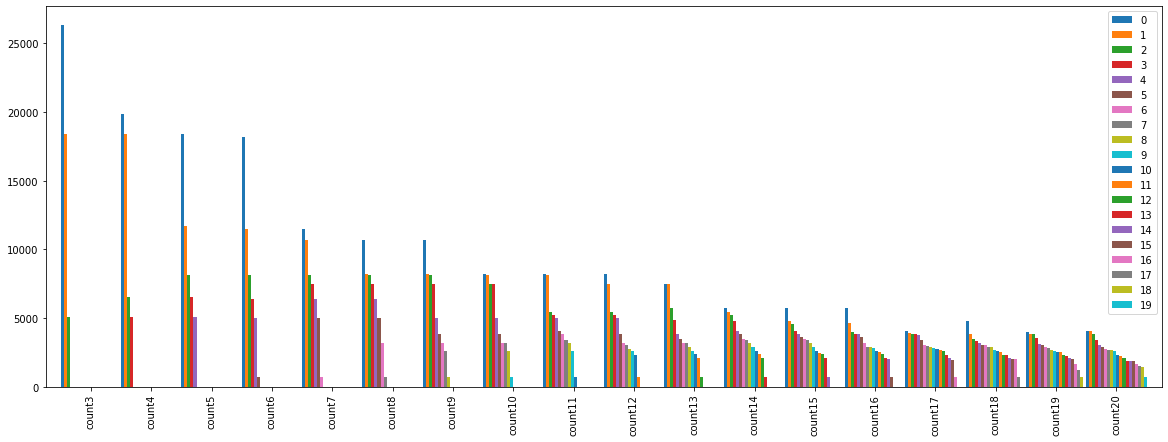

In [9]:
ax = results.transpose().plot.bar(figsize=(20, 7), width=1);

The clusters for each `k` value are relatively close in size, which is usually a good sign. We can also notice that some of the cluster sizes remain the same as we increase the number of cluster centers, which means those clusters are not easily broken up or reorganized into smaller clusters. Below is a more precise representation of these trends.

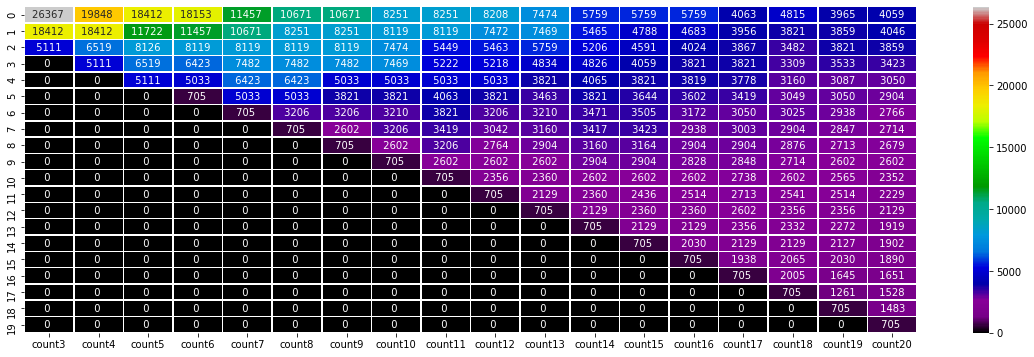

In [10]:
dv.display_cluster_sizes(results)

Indeed, for `k=7` the clusters are super stable, both going from `k=6` to `k=7` and from `k=7` to `k=8`, each time only one cluster changes, the one that contained 18153 datapoints in `k=6`  and the one that contained 11457 datapoints in `k=7` is broken up into two clusters. 

Based on the above three charts, `k=7` is the optimal number of clusters.

### Performing KMeans Clustering and Reversing PCA and Standardization on the Cluster Centers

If we run KMeans clustering for `k=7`, in this case we will get seven ten-dimensional centroids, that can be considered representative datapoints for our entire dataset. However, to interpret them, we still need to consider how PCA and standardization affected the original features.

In order to recover the original feature values for each centroid, we can to use the `PCA.inverse_transform()` method, to get our 15-dimensional datapoints, then call `StandardScaler.inverse_transform()` to scale back to the original values. To this end, I have created a general method, that we can utilize in case we decide to try a few different `k` values.

In [20]:
%%time

result_df = modeling.get_orig_cluster_centers(trans_data, columns, 7, pca2, scaler)
result_df['amount'] = 10**result_df['log_amount'] - 6.2
result_df.drop(columns=['log_amount'], inplace=True)
result_df.round(2)

Wall time: 3.67 s


,valid_flag,age,income,member_days,reward,difficulty,duration,web,mobile,social,count,gender,offer_type,amount
0,0.62,51.35,60873.04,675.79,6.87,6.89,5.35,1.0,1.0,1.0,11457,male,bogo,14.73
1,0.71,56.97,69395.20,633.37,2.16,8.70,8.18,1.0,1.0,1.0,7482,female,disc,29.32
2,0.63,56.43,69682.68,641.28,6.85,6.89,5.35,1.0,1.0,1.0,8119,female,bogo,24.43
3,0.34,53.70,65073.20,650.47,5.39,20.48,9.98,1.0,0.0,0.0,5033,male,disc,19.52
4,0.70,51.50,60045.65,657.21,2.16,8.70,8.19,1.0,1.0,1.0,10671,male,disc,17.63
5,0.66,55.08,60139.97,594.12,5.35,9.40,7.16,1.0,1.0,1.0,705,other,bogo,26.25
6,0.72,53.69,61384.99,644.49,10.11,10.03,7.24,0.0,1.0,1.0,6423,male,bogo,23.47


In [21]:
result_df.describe().round(2)

,valid_flag,age,income,member_days,reward,difficulty,duration,web,mobile,social,count,amount
count,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00
mean,0.62,54.10,63799.25,642.39,5.55,10.16,7.35,0.86,0.86,0.86,7127.14,22.19
std,0.13,2.21,4270.51,25.22,2.81,4.71,1.65,0.38,0.38,0.38,3618.04,5.12
min,0.34,51.35,60045.65,594.12,2.16,6.89,5.35,0.00,0.00,0.00,705.00,14.73
25%,0.62,52.60,60506.50,637.32,3.75,7.79,6.25,1.00,1.00,1.00,5728.00,18.57
50%,0.66,53.70,61384.99,644.49,5.39,8.70,7.24,1.00,1.00,1.00,7482.00,23.47
75%,0.70,55.76,67234.20,653.84,6.86,9.72,8.18,1.00,1.00,1.00,9395.00,25.34
max,0.72,56.97,69682.68,675.79,10.11,20.48,9.98,1.00,1.00,1.00,11457.00,29.32


Just as I suspected, some of the more meaningful dimensions of the cluster centers are fairly close to each other, including the `age`, `income`, `member_days`, and most importantly the `valid_flag` values, so we cannot really infer any meaningful trends from these clusters.

### Increasing the Number of Clusters for a More Granular Breakdown

As before, let's try to find a larger `k` to perform a more granular analysis. Based on the above charts, `k=17` looks optimal.

In [22]:
results_df = modeling.get_orig_cluster_centers(trans_data, columns, 17, pca2, scaler)
results_df['amount'] = 10**results_df['log_amount'] - 6.2
results_df.drop(columns=['log_amount'], inplace=True)

For better visibility, we can divide the cluster center data into four smaller tables:
- demographic info for total spendings over twenty dollars
- demographic info for total spendings under twenty dollars
- offer type info for clusters with over 60% valid purchases within 
- offer type info for clusters with under 60% valid purchases within 

In [23]:
results_df.head()

,valid_flag,age,income,member_days,reward,difficulty,duration,web,mobile,social,count,gender,offer_type,amount
0,0.744958,60.702090,82977.679595,657.917979,7.551783,7.186726,5.087839,1.0,1.0,1.0,2738,male,bogo,30.800575
1,0.988590,45.576712,47800.073605,486.919257,2.309696,8.778937,8.204049,1.0,1.0,1.0,3956,male,disc,11.118611
2,0.484823,57.543093,65679.214531,624.400484,4.792880,5.795565,6.122029,1.0,1.0,0.0,2356,female,bogo,30.539077
3,0.702053,56.930012,66296.038450,626.136165,10.114416,10.035073,7.232521,0.0,1.0,1.0,2602,female,bogo,30.151304
4,0.361711,56.774495,69963.303974,628.401334,5.396314,20.486796,9.974484,1.0,0.0,0.0,2129,female,disc,25.723858


In [24]:
columns_dem = ['age', 'income', 'member_days', 'gender', 'amount', 'valid_flag', 'count']
columns_cat = ['reward', 'difficulty', 'duration', 'web', 'mobile', 'social', 'offer_type',  'amount', 'valid_flag', 'count']
results_df[results_df['amount'] > 20][columns_dem].sort_values(by='amount', ascending=False).round(2)

,age,income,member_days,gender,amount,valid_flag,count
14,64.46,82951.34,662.59,female,46.75,0.75,4063
16,59.56,75445.20,859.09,male,37.46,0.91,3867
15,64.45,85643.44,655.04,female,36.14,0.70,3050
0,60.70,82977.68,657.92,male,30.80,0.74,2738
2,57.54,65679.21,624.40,female,30.54,0.48,2356
3,56.93,66296.04,626.14,female,30.15,0.70,2602
10,55.08,60139.97,594.12,other,26.25,0.66,705
4,56.77,69963.30,628.40,female,25.72,0.36,2129


In [25]:
results_df[results_df['amount'] < 20][columns_dem].sort_values(by='amount', ascending=False).round(2)

,age,income,member_days,gender,amount,valid_flag,count
7,51.48,58040.69,656.98,male,19.64,0.73,3821
11,52.56,57406.53,622.40,male,18.80,0.44,3003
6,48.06,53285.63,598.65,female,15.90,0.66,3419
9,51.44,61488.13,666.66,male,15.75,0.33,2904
8,47.11,52556.03,1378.64,male,11.98,0.65,1938
13,46.45,55215.99,640.46,female,11.98,0.67,2713
1,45.58,47800.07,486.92,male,11.12,0.99,3956
12,48.79,56123.54,619.34,male,10.10,0.00,2848
5,45.78,51875.10,370.64,male,6.72,0.66,3778


In [26]:
results_df[results_df['valid_flag'] > 0.6][columns_cat].sort_values(by=['valid_flag'], ascending=False).round(2)

,reward,difficulty,duration,web,mobile,social,offer_type,amount,valid_flag,count
1,2.31,8.78,8.20,1.0,1.0,1.0,disc,11.12,0.99,3956
16,2.16,8.73,8.25,1.0,1.0,1.0,disc,37.46,0.91,3867
14,2.18,8.73,8.18,1.0,1.0,1.0,disc,46.75,0.75,4063
0,7.55,7.19,5.09,1.0,1.0,1.0,bogo,30.80,0.74,2738
7,10.11,10.03,7.24,0.0,1.0,1.0,bogo,19.64,0.73,3821
3,10.11,10.04,7.23,0.0,1.0,1.0,bogo,30.15,0.70,2602
15,7.75,7.40,5.02,1.0,1.0,1.0,bogo,36.14,0.70,3050
13,7.63,7.26,5.06,1.0,1.0,1.0,bogo,11.98,0.67,2713
6,2.13,8.66,8.18,1.0,1.0,1.0,disc,15.90,0.66,3419
10,5.35,9.40,7.16,1.0,1.0,1.0,bogo,26.25,0.66,705


In [27]:
results_df[results_df['valid_flag'] < 0.6][columns_cat].sort_values(by=['valid_flag'], ascending=False).round(2)

,reward,difficulty,duration,web,mobile,social,offer_type,amount,valid_flag,count
2,4.79,5.80,6.12,1.0,1.0,0.0,bogo,30.54,0.48,2356
11,4.77,5.78,6.13,1.0,1.0,0.0,bogo,18.80,0.44,3003
4,5.40,20.49,9.97,1.0,0.0,0.0,disc,25.72,0.36,2129
9,5.39,20.48,9.98,1.0,0.0,0.0,disc,15.75,0.33,2904
12,1.94,8.55,8.08,1.0,1.0,0.0,disc,10.10,0.00,2848


### *Section Summary*

So what can we learn from this data?
- focusing on the demographic data, the most prominent trend is the strong positive correlation between income and spending. These higher earning (also slightly higher aged) groups often spend 2 to 4 times the required amount within the valid period of offers
- most likely to make purchases outside the valid duration of offers (or even without viewing them) is the younger (and slightly lower income) male population
- examining the offer type information, we find that customers are much more likely to take advantage of discount offers within their valid periods compared to buy-one-get-one offers
- again, the most important factor seems to be whether or not the offers were received via social media, in all clusters where that's the case, at least 65% of the purchses were made within their valid periods, but if it wasn't the case, less than 50% of the purcases were made within their valid periods 

In [28]:
# [['amount', 'valid_flag']]
df = results_df.corr().round(2)
df[['amount', 'valid_flag']].style.background_gradient(cmap='coolwarm')

,amount,valid_flag
valid_flag,0.3,1
age,0.96,0.15
income,0.89,0.15
member_days,0.06,0.05
reward,-0.08,0.13
difficulty,-0.03,-0.34
duration,0.09,-0.25
web,-0.07,-0.16
mobile,0.06,0.43
social,0.15,0.83


Examining the correlation between individual columns and the amount and valid_flag columns, we can conclude that this more granular approach highlights purchasing trends more accurately. 

We can also confirm that there is a strong correlation between total purchase amounts with `age` and `income`, and significant correlation between whether or not the offer was received via social media and if the purchase was made within the valid duration of the offers.

### Final Evaluation and Conclusions

This proved to be a challenging project, partly due to the nature of the data collection. It would have been helpful to add a QR code or some other unique id to the offers sent to the members, so we could determine exactly which events correspond to the same offer.

On my part, there is also room for improvement in terms of feature engineering. In retrospect, I should have given particular attention to which features were one-hot encoded and which were close to normally distributed, as this can have a pronounced effect on how the clusters form.

Overall, the project still succeeded in identifying significant trends in customer behavior, and this process can be further refine in the light of future data. 

